In [4]:
import os
import json
import cv2  # OpenCV 추가
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# =========================================================
# ✅ 경로 재확인
IMAGE_ROOT = r"D:\workspace\dataset\dataset\data\data\Training\source"
LABEL_ROOT = r"D:\workspace\dataset\dataset\data\data\Training\labeling"
OUTPUT_DIR = r"D:\workspace\yolo_dataset"
# =========================================================

# 클래스 맵 (그대로 유지)
CLASS_MAP = {
    ("대형차", "정상"): 0, ("대형차", "과적"): 1,
    ("중형차", "정상"): 2, ("중형차", "과적"): 3,
    ("소형차", "정상"): 4, ("소형차", "과적"): 5
}

def convert_to_yolo_resized():
    # 폴더 생성
    for split in ['train', 'val']:
        os.makedirs(os.path.join(OUTPUT_DIR, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_DIR, 'labels', split), exist_ok=True)

    print(f"📂 JSON 파일 검색 중...")
    json_files = glob.glob(os.path.join(LABEL_ROOT, "**", "*.json"), recursive=True)
    train_files, val_files = train_test_split(json_files, test_size=0.2, random_state=42)
    
    print("🚀 [용량 절약 모드] 이미지 리사이징(640px) 및 변환 시작...")
    
    def process_files(files, split):
        for json_path in tqdm(files, desc=f"Processing {split}"):
            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                file_info_list = data["FILE"] if "FILE" in data else [data]

                for info in file_info_list:
                    filename = info.get("FILE_NAME", "")
                    items = info.get("ITEMS", [])
                    if not filename or not items: continue

                    # 이미지 경로
                    rel_path = os.path.relpath(json_path, LABEL_ROOT)
                    rel_dir = os.path.dirname(rel_path)
                    img_src_path = os.path.join(IMAGE_ROOT, rel_dir, filename)

                    if not os.path.exists(img_src_path): continue

                    # 🔥 [핵심 수정] 이미지 읽어서 리사이징
                    img = cv2.imread(img_src_path)
                    if img is None: continue
                    
                    h_org, w_org, _ = img.shape
                    
                    # YOLO 학습용 사이즈(640)로 리사이징
                    # 비율 유지하면서 긴 쪽을 640으로 맞춤 (용량 대폭 감소!)
                    scale = 640 / max(h_org, w_org)
                    new_w, new_h = int(w_org * scale), int(h_org * scale)
                    img_resized = cv2.resize(img, (new_w, new_h))
                    
                    yolo_labels = []
                    
                    for item in items:
                        car_type = item.get("SEGMENT", "")
                        car_class = item.get("CLASS", "")
                        box = item.get("BOX", "")
                        
                        is_normal = "정상" in car_class
                        status = "정상" if is_normal else "과적"
                        
                        key = (car_type, status)
                        if key not in CLASS_MAP: continue
                        
                        class_id = CLASS_MAP[key]

                        # 좌표 변환 (정규화된 좌표는 이미지 크기가 바껴도 값은 똑같음! 중요!)
                        x_min, y_min, w, h = map(float, box.split(','))
                        
                        x_center = (x_min + w / 2) / w_org
                        y_center = (y_min + h / 2) / h_org
                        w_norm = w / w_org
                        h_norm = h / h_org
                        
                        yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

                    if yolo_labels:
                        # 🔥 리사이즈된 이미지 저장 (jpg 압축률 90)
                        save_path = os.path.join(OUTPUT_DIR, 'images', split, filename)
                        cv2.imwrite(save_path, img_resized, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
                        
                        txt_filename = os.path.splitext(filename)[0] + ".txt"
                        with open(os.path.join(OUTPUT_DIR, 'labels', split, txt_filename), 'w') as f:
                            f.write("\n".join(yolo_labels))

            except Exception:
                continue

    process_files(train_files, 'train')
    process_files(val_files, 'val')
    print("\n🎉 변환 완료! (용량 다이어트 성공)")

if __name__ == "__main__":
    convert_to_yolo_resized()

📂 JSON 파일 검색 중...
🚀 [용량 절약 모드] 이미지 리사이징(640px) 및 변환 시작...


Processing val: 100%|████████████████████████████████████████████████████████████| 65643/65643 [34:55<00:00, 31.33it/s]



🎉 변환 완료! (용량 다이어트 성공)


In [5]:
import yaml

# YAML 파일 내용 정의
data = {
    "path": "D:/workspace/yolo_dataset",  # 데이터셋 루트 (절대 경로)
    "train": "images/train",              # 학습 이미지 경로
    "val": "images/val",                  # 검증 이미지 경로
    "nc": 6,                              # 클래스 개수
    "names": [                            # 클래스 이름 리스트
        "Big_Normal",
        "Big_Overload",
        "Middle_Normal",
        "Middle_Overload",
        "Little_Normal",
        "Little_Overload"
    ]
}

# 파일 저장 경로
yaml_path = r"D:\workspace\yolo_dataset\data.yaml"

# 파일 생성 (이미 폴더가 있어야 하므로, 전처리 코드가 폴더를 만든 뒤에 실행하거나, 수동으로 폴더 생성 후 실행)
# 전처리 중이라면 폴더가 이미 생성되었을 테니 바로 실행해도 됩니다.
import os
os.makedirs(r"D:\workspace\yolo_dataset", exist_ok=True)

with open(yaml_path, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

print(f"✅ 설정 파일 생성 완료: {yaml_path}")

✅ 설정 파일 생성 완료: D:\workspace\yolo_dataset\data.yaml


In [ ]:
# 전처리 끝나면 바로 실행할 수 있게 미리 준비!
from ultralytics import YOLO

# 모델 로드 (가볍고 빠른 s 버전 추천)
model = YOLO('yolov8s.pt') 

# 학습 시작 (일단 20번만 돌려도 결과 잘 나옵니다)
results = model.train(
    data=r'D:\workspace\yolo_dataset\data.yaml',
    epochs=20,  # 밤새 돌릴 거면 50으로 늘려도 됨
    imgsz=640,
    batch=16,
    name='overload_detection'
)

New https://pypi.org/project/ultralytics/8.3.238 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.237  Python-3.8.20 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\workspace\yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=overload_detection

📸 테스트 이미지: D:\workspace\yolo_dataset\images\val\A03_B02_C00_D01_0712_E08_F03_486_3.jpg

image 1/1 D:\workspace\yolo_dataset\images\val\A03_B02_C00_D01_0712_E08_F03_486_3.jpg: 384x640 1 Little_Normal, 41.1ms
Speed: 4.1ms preprocess, 41.1ms inference, 13.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to D:\workspace\runs\detect\predict


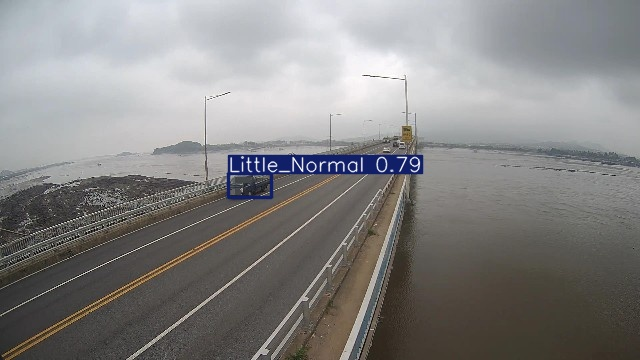

--------------------------------------------------
📸 테스트 이미지: D:\workspace\yolo_dataset\images\val\A03_B01_C04_D01_0819_E07_F08_610_3.jpg

image 1/1 D:\workspace\yolo_dataset\images\val\A03_B01_C04_D01_0819_E07_F08_610_3.jpg: 384x640 1 Little_Overload, 11.2ms
Speed: 1.0ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to D:\workspace\runs\detect\predict


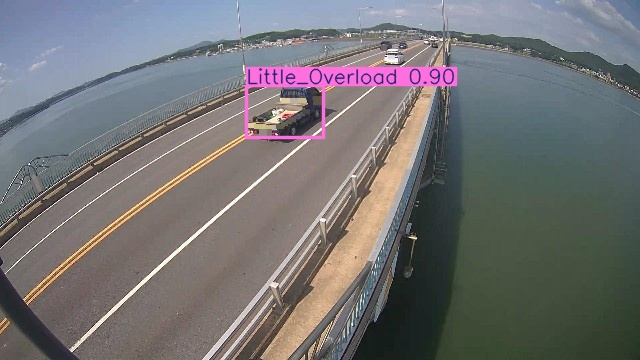

--------------------------------------------------
📸 테스트 이미지: D:\workspace\yolo_dataset\images\val\A03_B01_C02_D05_1201_I20_F06_3_2.jpg

image 1/1 D:\workspace\yolo_dataset\images\val\A03_B01_C02_D05_1201_I20_F06_3_2.jpg: 384x640 1 Little_Overload, 10.7ms
Speed: 1.1ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to D:\workspace\runs\detect\predict


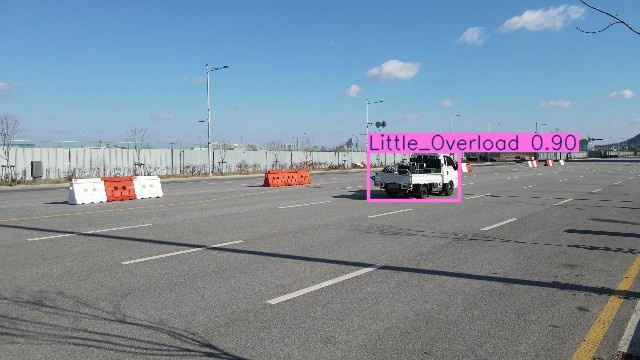

--------------------------------------------------


In [1]:
from ultralytics import YOLO
import glob
import random
from IPython.display import Image, display

# 1. 최고의 모델 불러오기
# (경로가 맞는지 꼭 확인하세요!)
best_model_path = r'D:\workspace\runs\detect\overload_detection2\weights\best.pt'
model = YOLO(best_model_path)

# 2. 검증용 이미지(val) 중에서 랜덤으로 3장만 뽑아보기
# (이미지가 있는 폴더 경로를 확인해주세요)
val_images = glob.glob(r'D:\workspace\yolo_dataset\images\val\*.jpg')
random_images = random.sample(val_images, 3)

# 3. 예측 및 결과 보여주기
for img_path in random_images:
    print(f"📸 테스트 이미지: {img_path}")
    
    # 예측 수행 (conf=0.5 : 확신이 50% 넘는 것만 표시)
    results = model.predict(source=img_path, conf=0.5, save=True)
    
    # 결과 이미지 보여주기 (results[0].save_dir에 저장됨)
    save_dir = results[0].save_dir
    filename = img_path.split('\\')[-1] # 파일명만 추출
    pred_img_path = f"{save_dir}\\{filename}"
    
    display(Image(filename=pred_img_path, width=600))
    print("-" * 50)

In [1]:
from ultralytics import YOLO

# 1. 최고의 모델 불러오기
model = YOLO(r'D:\workspace\runs\detect\overload_detection2\weights\best.pt')

# 2. 전체 데이터셋 검증 (그래프 자동 저장됨)
# split='val' : 검증 데이터셋 사용
metrics = model.val(data=r'D:\workspace\yolo_dataset\data.yaml', split='val')

print(f"최종 mAP50: {metrics.box.map50}")
print("✅ 검증 완료! runs/detect/val 폴더 안에 그래프가 생성되었습니다.")

Ultralytics 8.3.237  Python-3.8.20 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 7.92.8 MB/s, size: 63.2 KB)
val: Scanning D:\workspace\yolo_dataset\labels\val.cache... 63650 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 63650/63650  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3979/3979 7.5it/s 8:48<0.1s
                   all      63650      64273      0.957      0.959      0.985      0.963
            Big_Normal      10080      10171      0.976      0.995      0.994       0.98
          Big_Overload       5129       5129      0.991      0.999      0.995      0.983
         Middle_Normal       9845       9880      0.951      0.965       0.99      0.971
       Middle_Overload       9674       9679      0.975      0.946       0.99      0.971
         Little_Normal      12

In [1]:
from ultralytics import YOLO

# 1. 최고의 모델 로드 (경로 확인!)
model = YOLO(r'D:\workspace\runs\detect\overload_detection2\weights\best.pt')

# 2. 안드로이드용 TFLite 포맷으로 변환
print("🚀 모바일용 파일 변환 시작...")
# int8=True 옵션을 쓰면 용량이 1/4로 줄지만, 일단 안전하게 기본(float32)으로 뽑습니다.
model.export(format='tflite', imgsz=640)

print("\n✅ 변환 완료! 파일이 생성되었습니다.")

🚀 모바일용 파일 변환 시작...
Ultralytics 8.3.237  Python-3.8.20 torch-2.4.1+cu118 CPU (AMD Ryzen 5 3600 6-Core Processor)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'D:\workspace\runs\detect\overload_detection2\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (42.8 MB)
requirements: Ultralytics requirements ['tf_keras<=2.19.0', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3', 'protobuf>=5'] not found, attempting AutoUpdate...
WARNING Retry 1/2 failed: Command 'pip install --no-cache-dir "tf_keras<=2.19.0" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING Retry 2/2 failed: Command 'pip install --no-cache-dir "tf_keras<=2.19.0" "ai-edge-litert>=1.2.0" "onnx2tf>=1.26.3" "protobuf>=5" --extra-index-url https://pypi.ngc.nvidia.com' returned non-zero exit status 1.
WARNING requirements:  Command 'pip install --n